In [550]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

In [551]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

In [552]:
data_ = pd.read_csv("../data/FilteredData.csv")

In [553]:
def SingleAtomRemover(x):
    singleAtom = ["[Kr]","[Ne]","C","[Li]","O","[Ar]",'[Xe]']
    if x in singleAtom:
        return 1
    else: 
        return 0  

In [554]:
data = data_[["Structure","BBB+/BBB-"]]

In [555]:
data.replace({"BBB+":1,"BBB-":0},inplace=True)

In [556]:
data.rename(columns={"Structure":"SMILES","BBB+/BBB-":"LABELS"},inplace=True)

In [557]:
data["Isit"] = data["SMILES"].apply(SingleAtomRemover)

In [558]:
### Remove single element
data.drop(data[data["Isit"] == 1].index,inplace=True)

In [559]:
data.to_csv(r"raw/data.csv")

In [560]:
from torch_geometric.data import InMemoryDataset, download_url, Dataset, Data
from dgllife.utils import (CanonicalAtomFeaturizer,
                           one_hot_encoding,
                           atom_implicit_valence_one_hot,
                           atom_total_degree_one_hot,
                           atomic_number_one_hot,
                           atom_hybridization_one_hot,
                           atom_is_in_ring_one_hot,
                           atom_is_aromatic_one_hot
                          )
from rdkit import Chem

class BBBDataset(Dataset): ### All dataset will store in RAM
    
    def __init__(self,root,transform = None, pre_transform=None,pre_filter=None,one_hot=False):
        
        """
        root: where the dataset shoul be stored. The folder will split into raw_dir (downloaded dataset)
        and processed_dir (processed data).

        """
        self.one_hot = one_hot
        super().__init__(root, transform, pre_transform, pre_filter)
        
    
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        dataArray = self.data[["SMILES","LABELS"]].to_numpy().squeeze()
        
        j = 0
        for i in tqdm(dataArray):
            processed_data = self.smiles2graph(*i,one_hot=self.one_hot)
            
            nodes_feats = processed_data["X"]
            label = processed_data["Y"]
            edge_feats = processed_data["E"]
            adj_mat = processed_data["A"]
            smiles = processed_data["SMILES"]
            
            
            ### create data object
            data = Data(x=nodes_feats,edge_index=adj_mat,edge_attr=edge_feats,y=label,smiles=smiles)
            
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def smiles2graph(self, smiles,label,one_hot=False):
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            raise("Smiles not parsed by rdkit")

        adj_matrix = GetAdjacencyMatrix(mol) ### Adjacency matrix
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo,(2,-1))
        
        if one_hot:
            valence =[]
            degree = []
            atoms =  []
            hybrid = []
            mass =   []
            aromatic = []
            for idx,atom in enumerate(mol.GetAtoms()):
                valence.append(atom_implicit_valence_one_hot(atom))## Implicit valence
                degree.append(atom_total_degree_one_hot(atom))## total degree
                atoms.append(atomic_number_one_hot(atom))## total degree
                hybrid.append(atom_hybridization_one_hot(atom))## total degree
                aromatic.append(atom_is_aromatic_one_hot(atom)) ## aromatic
                mass.append([atom.GetMass()])## total degree
                
            features  = torch.cat([torch.tensor(valence),
                                  torch.tensor(degree),
                                  torch.tensor(atoms),
                                  torch.tensor(hybrid),
                                  torch.tensor(aromatic),],
                                  axis=1)
            ##torch.tensor(mass)],
            
        else:
            
            features = np.zeros((mol.GetNumAtoms(),5),) ### Feature Matrix
            for idx,atom in enumerate(mol.GetAtoms()):
                features[idx,0] = atom.GetAtomicNum()
                features[idx,1] = atom.GetDegree()
                #feature_array[idx,2] = atom.GetFormalCharge()
                features[idx,2] = atom.GetHybridization()
                features[idx,3] = atom.GetExplicitValence()
                features[idx,4] = atom.GetMass()
           
        label_array = torch.tensor([0]) if label == 0 else torch.tensor([1])
        
#         if label == 0:
#             label_array = torch.tensor([0])
#         else:
#             label_array = torch.tensor([1])

        all_edge_feats = []
        for bond in mol.GetBonds():
            Edge_feature = []
            # Feature 1: Bond type (as double)
            Edge_feature.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            Edge_feature.append(bond.IsInRing())
            # Append edget features to matrix (twice, per direction)
            all_edge_feats += [Edge_feature, Edge_feature]

        all_edge_feats = np.asarray(all_edge_feats)

        return {"A": torch.tensor(coo,dtype=torch.long),
               "X": torch.tensor(features,dtype=torch.float32),
               "Y":torch.tensor(label_array,dtype=torch.float32),
                "E":torch.tensor(all_edge_feats,dtype=torch.float32),
                "SMILES":smiles}
    
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [561]:
dataset = BBBDataset(root=".",one_hot=True)

Processing...
100%|█████████████████████████████████████████████████████████████████████████████| 3330/3330 [00:07<00:00, 453.07it/s]
Done!


In [562]:
from dgl.nn import WeightAndSum
from torch_geometric.nn import GlobalAttention
from torch.nn import Sequential

In [563]:
from torch_geometric.nn import global_mean_pool


class PyGAT(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        """
        First GAT layer with 3 attention head for each node
        """
        self.GAT_Conv1 = GATConv(in_channels= -1, 
                                 out_channels= 8,
                                 heads = 3,
                                 concat=True)
        
        self.GAT_Conv2 = GATConv(in_channels= 24, 
                                 out_channels= 16,
                                 heads = 1,)
        
        self.GateNN = Sequential(nn.Linear(in_features=(16),out_features=1),)
        
        self.fC_layer = nn.Linear(16,8)
        
        self.GlobalAtt = GlobalAttention(self.GateNN,)
        
        self.fc_1 = nn.Linear(16,1)
                 
    def forward(self,data):
        
        ### Extracting data from batch
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.GAT_Conv1(x=x,edge_index=edge_index)
        
        x = F.elu(x)
        
         ##x = F.dropout(x, p=0.5, training=self.training) 
        
        x = self.GAT_Conv2(x,edge_index)
        
        x = self.GlobalAtt(x,batch)
        
        x = F.sigmoid(self.fc_1(x))
        
        return x
        
        
        

In [564]:
smallData = dataset[:500:]

In [565]:
smallData

BBBDataset(500)

In [578]:
### Splitting of data
from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dataset,[2331,666,333])

trainloader = DataLoader(train_set,shuffle=True,batch_size=256,num_workers=4)

validloader = DataLoader(valid_set, shuffle=True,batch_size=256,num_workers=4)

testloader = DataLoader(test_set, shuffle=True,batch_size=256,num_workers=4)

In [579]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = PyGAT()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=0.00001)

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

PyGAT(
  (GAT_Conv1): GATConv(-1, 8, heads=3)
  (GAT_Conv2): GATConv(24, 16, heads=1)
  (GateNN): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
  (fC_layer): Linear(in_features=16, out_features=8, bias=True)
  (GlobalAtt): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  ), nn=None)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
)

In [580]:
from sklearn.metrics import accuracy_score

In [581]:
def accuracy_counter(y_prob,y_true):
    
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    
    return (accuracy,)

In [583]:
def train():
    
    net.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    accuracy = accuracy_counter(proab,y_true)
    
    return (av_loss,accuracy)
        

In [584]:
@torch.no_grad()
def test(loader):
    
    net.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter(proab,y_true)
    return (val,accuracy)

In [ ]:
epochs = 100

## Accuracy
traine_accuracy = []
vale_accuracy = []
teste_accuracy = []

## Loss
epoch_loss = []
valida_loss = []
test_loss_full = []

for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1 = train()
    
    train_loss2,train_accuracy2 = test(trainloader)
    
    val_loss,val_accuracy = test(validloader)
    
    test_loss,test_accuracy = test(testloader)
    
    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    test_loss_full.append(test_loss)
    
    ## accuracy
    traine_accuracy.append(train_accuracy1[0])
    vale_accuracy.append(val_accuracy[0])
    teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')

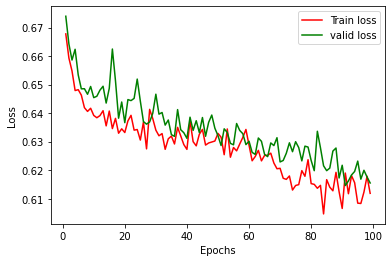

In [574]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[j.cpu().detach().numpy() for j in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

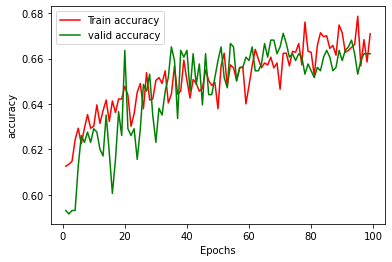

In [575]:
plt.plot([i for i in range(1,epochs)],[i  for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[j for j in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

In [234]:
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")
print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss|   Mean: 0.6113587021827698   std: 0.016530267894268036
validation loss| Mean: 0.6173926591873169  std: 0.013263992965221405
Test loss|       Mean: 0.6082834601402283   std: 0.01942029781639576


In [ ]:
print(f"Training accuracy  |   Mean: {torch.tensor(epoch_loss).mean()} ")
print(f"validation accuracy| Mean: {torch.tensor(valida_loss).mean()}  ")
print(f"Test loss accuracy |       Mean: {torch.tensor(test_loss).mean()} ")